In [1]:
# Import packages
import os
import nglview as ng
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

## **Part1: Ibuprofen in water**

We start by simulating ibuprofen molecule in water. We build and simulate an extremely simple system to understand the workflow of MD simulations with GROMACS and how the theory connects to practice. 

Before we can start with the simulations, we will need the following files:
- Atom positions (.pdb, .gro)
- Topology and force field (.itp, .top)
- Simulation parameters (.mdp)

In [ ]:
# Move to the working directory for the ibuprofen simulations
os.chdir('../simulations/ibuprofen_in_water/')

### 1.1 Building the system

The SMILES for ibuprofen has been obtained from [PubChem](https://pubchem.ncbi.nlm.nih.gov/compound/Ibuprofen). The CHARMM-GUI [Ligand Reader & Modeler](https://doi.org/10.1002/jcc.24829) was utilized for generating the 3D structure file, topology and force field paramaters used in the following simulations to model ibuprofen.

- **NOTE**: Obtaining the 3D starting structure for larger biomolecules, such as proteins, is more complex. In these cases, [Protein Data Bank](https://www.rcsb.org/) can be used for obtaining structures determined experimentally through crystallography and NMR. For example, in the [Introductory tutorial](https://tutorials.gromacs.org/md-intro-tutorial.html), the crystal structure for a protein is obtained from Protein Data Bank and subsequently cleaned before starting the simulations. 

#### Understanding the structure file

Let's start building our system using the 3D structure of ibuprofen. We can use nglview to visualize the structure file (.gro).

In [ ]:
# Visualize the 3D structure (zoom by scrolling, rotate by dragging)
!cp 'inputs/IBU.gro' .
view = ng.show_file('IBU.gro')
view

If we look at the structure file as plain text, we see that GROMACS structure files are in .gro format, which follows always follows the format:
- Title of the structure file
- Number of atoms
- Each atom on separate lines
- Box vectors

In [ ]:
# Print the first five rows in the structure file
!head -5 'IBU.gro'

We see that each atom belong to **residue(s)**. Each line contains residue number (1), residue name (IBU), atom name, atom number, and atom xyz coordinates. Additionally the gro file can contain information about velocity.

If we print out the last line of the .gro file, we can see that is empty. That is because we have not defined the simulation box, so let's do that next.

In [ ]:
!tail -1 'IBU.gro'

#### Build the simulation box

Next, we have to build the simulation box for our molecule. In this case, we center the molecule (**-c**), build a cubic box (**-bt cubic**) and then determine the box size so that the molecule is 1.0 nm from the box edge (**-d 1.0**).

In [ ]:
# Generate a simulation box
!gmx editconf -f IBU.gro -o IBU_box.gro -c -bt cubic -d 1.0

------------------------------------------------------------------------------------------------------------------
**<font color='red'>Question:</font>** Why do we set the distance between ibuprofen and the box edge?

<details>
  <summary><strong>Click to answer:</strong></summary>
  <p> Determining large enough box size is crucial. We do this to prevent the molecule from interacting with its periodic image. </p>
</details> 
<br>

**<font color='red'>EXTRA:</font>** Why do we set the distance to 1.0 nm?

<details>
  <summary><strong>Click to answer:</strong></summary>
  <p> We will use CHARMM36m force field with cut-off for non-bonded interactions at 1.2 nm. Due to the periodic boundary conditions, there will be 2 x 1.0 nm between two periodic images and thus -d 1.0 is sufficient.</p>
</details>

------------------------------------------------------------------------------------------------------------------

If we print the last line from the newly generated .gro file, we see that 0 0 0 has been replaced by box vectors:

In [ ]:
!tail -1 'IBU_box.gro'

#### Solvate

Now that we have the simulation box, we can will it with water molecules and save the output coordinates into a new .gro file.

In [ ]:
# Copy the topology starting file
!cp 'inputs/topol.top' . 

# Add water
!gmx solvate -cp IBU_box.gro -cs spc216.gro -o IBU_solvated.gro -p topol.top 

------------------------------------------------------------------------------------------------------------------
**<font color='red'>Question:</font>** Look at the output of gmx solvate: how many lines do you think were added to the .gro file?

<details>
  <summary><strong>Click to answer:</strong></summary>
  <p> The output says ''Generated solvent containing 2733 atoms in 911 residues'', thus 2733 new lines were added to the .gro file, one for each atom </p>
</details> 

------------------------------------------------------------------------------------------------------------------

#### Add ions

Next, we will use **gmx genion** tool to add ions to the system. Since gmx genion needs portable binary run input file (.tpr), we need to use another tool, **gmx grompp**, to process structure file (.gro), topology (.top) and an empty simulation parameter file (.mdp) into a tpr file.  

Once we have the binary run input file, we use gmx genion to select ion concentration as 0.15 M, and add potassium and chloride ions to produce neutral charge. 

In [ ]:
# Create empty simulation parameter file
!touch empty.mdp

# Grompp, ignore warnings caused by the empty mdp file
!gmx grompp -f empty.mdp -c IBU_solvated.gro -p topol.top -o genion.tpr -maxwarn 1

In [ ]:
# Replace water molecules with ions to produce charge neutral system with 0.15 M KCl concentration
!printf "SOL\n" | gmx genion -s genion.tpr -o IBU_solvated_ions.gro -conc 0.15 -p topol.top -pname K -nname CL -neutral

Now our starting structure is ready!

In [ ]:
# Visualize the 3D structure
view = ng.show_file('IBU_solvated_ions.gro')
view.add_point()
view

### 1.2 Understanding the topology and the force field files

Before we can start with the simulations, we need to define how the atoms interact with each other.

Our goal is to simulate drug-membrane interactions with CHARMM36m chosen as the force field for the lipids. Therefore, a compatible CHARMM General Forcefield [(**CGenFF**)](https://doi.org/10.1002/jcc.21367) was chosen to model ibuprofen. The force field parameters for ibuprofen were obtained using CHARMM-GUI's Ligand Reader & Modeler, which uses [the CGenFF tool](https://doi.orgdoi/10.1021/ci3003649). For water, we use CHARMM-compatible TIP3P water model. For more information about topology files, see the [GROMACS manual](https://manual.gromacs.org/2024.5/reference-manual/topologies/topology-file-formats.html#tab-topfile2).

Let's look at the topology file for our system:

In [ ]:
!cat 'topol.top'

------------------------------------------------------------------------------------------------------------------
We include the contents of a bunch of other files using #include. For the topology to work as expected, we have to first include the force field file, **forcefield.itp**. This file contains the atom types in your system, as well as bonded and nonbonded parameters. 

The atom types will have four static properties:    
- mass in atomic mass units
- partial charge
- Lennard-Jones parameters sigma (σ, nm) and epsilon (ε, kJ/mol)

After the atom types, the forcefield.itp lists parameters for bonds, pairs, angles and dihedrals these atoms in your system. 

------------------------------------------------------------------------------------------------------------------

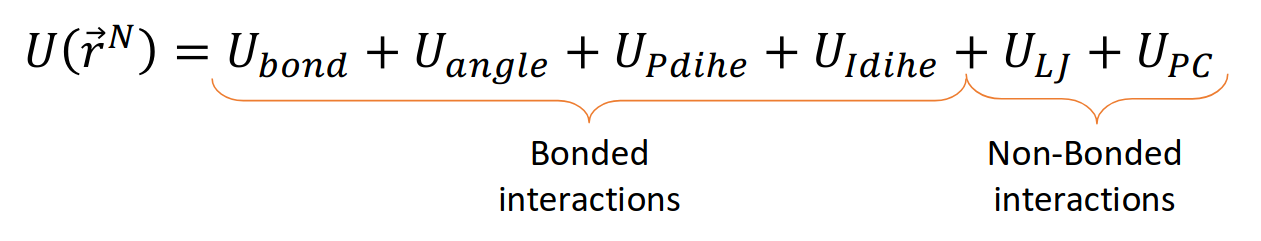

------------------------------------------------------------------------------------------------------------------
The molecular topology files (e.g., **IBU.itp**) contain information about:
- Molecule type (molecule name and how many bonds away the atoms will be excluded from non-bonded interactions)
- Atom info, including partial charges and mass (NOTE: The atom order has to be the same as in the .gro file!!!)
- Information about which atoms form pairs, bonds, angles and dihedrals
- (information about position restraints)

Take a look at the atom info and the first 5 bonds defined in the IBU.itp file:

------------------------------------------------------------------------------------------------------------------

In [ ]:
# Atom info
!grep "atoms" -A 34 toppar/IBU.itp 
!echo ""
# First 5 bonds
!grep "bonds" -A 5 toppar/IBU.itp

**<font color='red'>Question:** Look at the second bond defined in the IBU.itp under [ bonds ]. 
- What are the names of the atoms forming the bond?
- What about their atom types?

<details>
  <summary><strong>Click to answer:</strong></summary>
  <p> Atom names: C1-H1, atom types: CG331-HGA3 </p>
</details> 


In [ ]:
# If you want to take a look at the force field file, uncomment the next line by deleting #
#!cat toppar/forcefield.itp

In [ ]:
# If you want to take a look at the topology file, uncomment the next line by deleting #
#!cat toppar/IBU.itp

### Simulations

#### Energy minimization

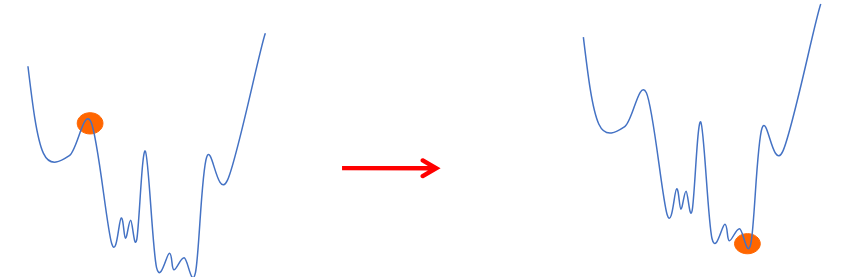

Before doing actual MD simulations, we need to get the potential energy $U(\vec{r}^N)$ smaller. For this, we will use the **steepest descent** algorithm. Let's look at the simulation parameters for the energy minimization in em.mdp:

In [ ]:
em_parameters='inputs/em.mdp'
!cat $em_parameters

------------------------------------------------------------------------------------------------------------------
**<font color='red'>Question:</font>** Which parameter defines when the energy minimization stops?

<details>
  <summary><strong>Answer:</strong></summary>
  <p>Energy minimization will go on for maximum number of 5000 steps (nsteps = 5000); it will stop if the maximumn force in the system is smaller than 1000 kJ mol-1 nm-1 (emtol = 1000.0). </p>
</details>

------------------------------------------------------------------------------------------------------------------

Now we have all necessary files to run the energy minimization. Before we can set off the minimization, we have to generate a binary run input file (.tpr) via **gmx grompp**. Then we start the minimization with **gmx mdrun**.

In [ ]:
# grompp
!gmx grompp -f $em_parameters -c IBU_solvated_ions.gro -p topol.top -o em.tpr

In [ ]:
# Start the energy minimization
!gmx mdrun -deffnm em -v

Since we used -deffnm option, all output files will have a default file name "em":

In [ ]:
# List all files starting with em
!ls em*

Let's analyze the potential energy from the portable energy file (em.edr) using gmx energy. 

In [ ]:
# Get the potential energy from the gromacs energy file
!printf "Potential\n0\n" | gmx energy -f em.edr -o em_pot.xvg -xvg none

# Plot
DATA = np.loadtxt('em_pot.xvg')

step = DATA[:,0]
energy = DATA[:,1]

plt.plot(step, energy)
plt.title('Potential energy')
plt.xlabel('Step')
plt.ylabel('Energy (kJ/mol)')

#### Equilibration (NVT)

Now we can start simulating the dynamics! Sometimes it's a good idea to first add temperature to the system, i.e., perform the simulation under canonical ensemble. Let's look at the simulation parameters:

In [ ]:
nvt_parameters='inputs/nvt.mdp'
!cat $nvt_parameters

Grompp similar to the previous step with the energy minimization:

In [ ]:
!gmx grompp -f $nvt_parameters -c em.gro -p topol.top -o nvt.tpr

In [ ]:
# Start the energy minimization
!gmx mdrun -deffnm nvt -v 

------------------------------------------------------------------------------------------------------------------
The run will take approximately 5-6 minutes. Meanwhile, let's look at some of the run parameters:

- **integrator = md** ; use leap-frog algorithm for integrating the Newton’s equations of motion
- **tcoupl = v-rescale** ; temperature coupling using velocity rescaling with a stochastic term, time constant and target temperature are set separately
- **gen-vel = yes** ; generate velocities with Maxwell distribution at temperature gen-temp (which is 310.15 K in our case)

------------------------------------------------------------------------------------------------------------------

Let's visualize our simulation:

In [ ]:
# Load trajectory 
traj = md.load('nvt.xtc', top='nvt.gro')

# View trajectory
view = ng.show_mdtraj(traj)
view.add_point()
view.center()
view.camera='orthographic'
view.add_unitcell()
view

We can then check the convergence of temperature using the gmx energy tool and the energy file:

In [ ]:
# Use the gmx energy to analyze temperature information
!printf "Temperature\n0\n" | gmx energy -f nvt.edr -o nvt_temperature.xvg -xvg none

# Plot
DATA = np.loadtxt('nvt_temperature.xvg')

time = DATA[:,0]
temperature= DATA[:,1]

plt.plot(time, temperature)
plt.title('Temperature during a simulation under an NVT ensemble')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')

#### More equilibration under an NPT ensemble and the production run

Now we can move on to the 

In [ ]:
npt_parameters='inputs/production.mdp'
!cat $npt_parameters

In [ ]:
!gmx grompp -f production.mdp -c nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

Only execute the next cell if you want to simulate the system yourself. 

In [ ]:
#!gmx mdrun -deffnm npt -nsteps 50000 -v

To save time, we can visualize simulations that have been prior the practical session.

In [ ]:
# Define file paths for a 10 ns simulation
ibu_edr='ibu_full_simulation/run_IBU_solvated_ions.edr'
ibu_tpr='ibu_full_simulation/run_IBU_solvated_ions.tpr'
ibu_xtc='ibu_full_simulation/run_IBU_solvated_ions.xtc'
ibu_gro='ibu_full_simulation/run_IBU_solvated_ions.gro'

# Make molecules whole again (they will still jump across the pbc)
!printf "0\n" | gmx trjconv -s $ibu_tpr -f $ibu_xtc -o ibu_nopbc.xtc -pbc mol

In [ ]:
# Load trajectory
traj = md.load('ibu_nopbc.xtc', top=ibu_gro)

# View with nglview
view = ng.show_mdtraj(traj)
view.add_point()
view.center()
view.camera='orthographic'
view.add_unitcell()
view

Now that we have been simulating the simulation under NPT ensemble, we can obtain the pressure of the system during the simulation. 
We will see that the pressure fluctuates quite a bit; this is normal and expected.

In [ ]:
# Get the pressure term in the system over time
!printf "Pressure\n0\n" | gmx energy -f $ibu_edr -o npt_pressure.xvg -xvg none

# Plot
DATA = np.loadtxt('npt_pressure.xvg')

time = DATA[:,0]
pressure= DATA[:,1]

plt.plot(time, pressure)
plt.title('Pressure during a simulation under an NPT ensemble')
plt.xlabel('Time (ps)')
plt.ylabel('Pressure ()')

## Part2: Ibuprofen with POPC membrane

Next, we will visualize and analyze simulations performed prior to the practical session. We simulate 128-lipid POPC (1-palmitoyl-2-oleoyl-sn-glycero-3-phosphocholine, 16:0/18:1 PC) membrane. This lipid was used in early eukaryote membrane models (see [Marrink et al. (2019)](https://www.doi.org/10.1021/acs.chemrev.8b00460)). 

The goals of this exercise are to:
- Discuss how to build membrane models and other things to consider
- Understand how different observables have to be considered before deciding where to start analysis

In [ ]:
# Move to the working directory for the full ibuprofen simulations
current_path = os.getcwd() # get current path
dir_path = os.path.dirname(current_path) # parent directory
target_path = os.path.join(dir_path, 'memb_ibu_full_simulation') 
os.chdir(target_path) # move to target path

memb_ibu_edr='run_memb_ibu.edr'
memb_ibu_tpr='run_memb_ibu.tpr'
memb_ibu_xtc='run_memb_ibu.xtc'
memb_ibu_gro='run_memb_ibu.gro'

Make molecules whole for visualization:

In [ ]:
!printf "0\n" | gmx trjconv -s $memb_ibu_tpr -f $memb_ibu_xtc -o memb_ibu_nopbc.xtc -pbc mol -e 100000

Let's visualize the trajectory. 

- What can you observe about the membrane?
- What about the ibuprofen?

In [ ]:
traj = md.load('memb_ibu_nopbc.xtc', top=memb_ibu_gro)

view = ng.show_mdtraj(traj)
view.clear_representations('IBU')

view.add_spacefill('IBU', color='orange')

view.camera='orthographic'
view.add_unitcell()
view

In [ ]:
del traj
del view

Let's see if we can see some observables converging. We will analyze next 
- "Area per lipid" by dividing the box xy area with the number of lipids on one leaflet. Note: a more precise way of analyzing area per lipid would be through e.g., Voronoi tesselation (see [Lukat et al. (2013)](https://www.doi.org/10.1021/ci400172g)).
- Number of contacts within cutoff
- Distance between membrane center and ibuprofen

I've made analysis.ndx index file for selecting the atom groups for analysis.

In [ ]:
# Box vectors, xy
!printf "Box-X \n Box-Y \n 0 \n" | gmx energy -f $memb_ibu_edr -o box_xy.xvg -xvg none -e 100000

# Number of contacts within cutoff
!printf "IBU \n Water \n" | gmx mindist -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis.ndx -on ncontacts_ibu.xvg -xvg none -e 100000

# Distance between membrane center and IBU
selection="com of resname IBU plus com of resname POPC"
!gmx distance -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis.ndx -oxyz distz.xvg -xvg none -e 100000 -select "$selection"

Plot all three analyses:

In [ ]:
def plot_xvg(analysis_type, ax):
    """
    Plot .xvg files
    
    analysis_type (str): 'distz', 'ncontacts' or 'box_xy' 
    ax (matplotlib.axes.Axes) = axis to plot on
    """

    # Check if file exists:
    
    DATA = np.loadtxt(f'{analysis_type}.xvg')

    time = DATA[:,0]

    if analysis_type == 'distz':
        result = DATA[:,3]
        title = 'Distance between IBU-com and membrane-com in Z direction'
        ylabel = 'Distance (nm)'
    elif analysis_type == 'ncontacts_ibu':
        result = DATA[:,1]
        title = 'Number of contacts between IBU and Water (< 0.6 nm)'
        ylabel = 'Number'
    elif analysis_type == 'box_xy':
        nlipids = 64
        result = (DATA[:,1]*DATA[:,2])/nlipids
        title = 'Area per lipid'
        ylabel = 'Area per lipid ($nm²$)'
    else:
        raise ValueError('Analysis type must be one of the following: distz, ncontacts, box_xy')

    ax.plot(time, result)
    ax.set_title(title, weight='bold')
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel(ylabel)

analyses = 'distz', 'ncontacts_ibu', 'box_xy'

fig, axs = plt.subplots(3,1, sharex=True)

for ax, analysis in zip(axs, analyses):
    plot_xvg(analysis, ax)

fig.tight_layout()

- Do you think the membrane is converged?
- What other analyses could you do to assess whether you can consider the simulation a production run?
- Where would you start the analysis?

Our final task is to do a mass density analysis. 

In [ ]:
# Mass density
!printf "POPC \n POPC \n P \n IBU \n Water \n" | gmx density -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis.ndx -o mass_density.xvg -ng 4 -sl 100 -d z -center -b 50000 -e 100000 -xvg none

In [ ]:
DATA = np.loadtxt('mass_density.xvg')

atom_groups = 'POPC', 'P', 'IBU', 'Water'
colors = 'grey', 'orange', 'red', 'blue'

for i, ag in enumerate(atom_groups):
    color = colors[i]
    distance = DATA[:,0]

    if ag != 'IBU':
        density = DATA[:,i+1]
    else:
        density = DATA[:,i+1]*20
        ag=f'{ag} x20'

    plt.plot(distance, density, color=color, label=ag)

plt.legend()
plt.title('Partial density')
plt.xlabel('z-coordinate (nm)')
plt.ylabel('Density ($kgm^{⁻3}$)')

What next?
- Doing replicates
- Analyzing the effect of ibuprofen concentration
- Free energy calculations with e.g. Accelerated Weighted Histogram method --> assessing permeation?